# Generative Adversarial Networks

Como vimos em autocodificadores variacionais, há possivelmente muitos códigos latentes que representam uma certa imagem. Também sabemos que há muito ruído no espaço de entrada, o que nos permite representar uma entrada por um código latente muito menor. 

Logo, talvez seja possível introduzir ruído em uma entrada, cuidadosamente, sem modificá-la de forma perceptível aos olhos humanos, mas modificando-a significativamente em sua representação latente (ou seja, o "ruído" introduzido não é de fato ruído, mas valores escolhidos cuidadosamente para não mudarem significativamente a relação entre os atributos, mas levando-os para fora das suas faixas de valores esperados). Abaixo, temos uma ilustração desta ideia, onde à imagem de um panda é adicionado ruído $\epsilon$, de forma que a imagem resultante é vista como um gibão pela rede neural, embora pareça ainda um panda para um ser humano.

<img src="images/adversarial_img_1.png" alt="GAN" style="width: 500px;"/>

Este é naturalmente um problema, uma vez que é possível fazer redes neurais cometerem erros modificando cuidadosamente os exemplos dados. Vários estudos têm sido realizados para tornar estes modelos mais robustos a este tipo de erro. Uma estratégia, por exemplo, é treinar a rede neural com exemplos destes casos (chamados adversariais), o que nos leva à seguinte questão:

Seria possível criar um modelo discriminador $D$ capaz de aprender o que faz uma imagem real ser real ao olho humando e, assim, discriminá-la de imagens falsas? 

Se sim, então é viável imaginar também que seria possível criar _modelos geradores de imagens falsas que, em competição com $D$, fossem capazes de criar imagens tão convincentes a ponto de $D$ não ser mais capaz de diferenciá-las de imagens verdadeiras!_ 

O _insight_ acima nos leva à proposição das Redes Geradoras Adversariais (GANs -- _Generated Adversarial Networks_, Goodfellow _et al_, 2014 -- https://arxiv.org/abs/1406.2661). GANs são combinações de redes neurais que treinam de forma competitiva. Mais especificamente, GANs são formadas por duas redes, uma discriminadora (_D_) e uma geradora (_G_). Sem perda de generalidade, suponha que temos uma GAN projetada para gerar imagens. A rede discriminadora _D_ desta GAN é treinada em imagens reais e imagens da rede geradora _G_ e tem por objetivo determinar _que imagens são as de G_. O objetivo de _G_, por sua vez, é gerar imagens que _D_ não consiga discernir das imagens reais. Logo, se _G_ for bem sucedida, ela gera imagens mais realistas.  

Esta ideia tem sido aplicada com grande sucesso na resolução de muitas tarefas (geração de faces, ambientes, fotos; geração de imagens apartir e fotos; geração de texto apartir de exemplos de texto; geração de imagens apartir de exemplos de imagens; criação e analogias; criação de imagens/textos apartir de exemplos; obtenção de imagens de alta resolução de imagens de baixa resolução, etc), de forma a tornar modelos geradores especialmente úteis atualmente. 

## Como funcionam GANs?

Para entendermos melhor, a figura abaixo ilustra uma GAN. Nesta figura, $p_{data}(x)$ é a distribuição de probabilidade real dos dados; $x$ é uma amostra tirada de $p_{data}(x)$; $p(z)$ é a distribuição de probabilidade do gerador, onde $z$ é uma amostra de $p(z)$; G(x) é a rede geradora e D(x) a discriminadora.

<img src="images/gan1.jpg" alt="GAN" style="width: 500px;"/>

A rede geradora $G$ gera um novo dado apartir de uma amostra aleatória $z$ obtida da distribuição de probabilidade $p(z)$. O dado gerado é fornecido como entrada para o discriminador $D(x)$. A tarefa do discriminador é distinguir entradas reais das geradas. Para isso, ele obtem uma entrada $x$ da distribuição de dados reais $p_{data}(x)$. Assim, $D(x)$ apenas tem que classificar as entradas, forncecendo uma estimativa probabilística sobre se elas são geradas ou reais.

O treinamento da GAN pode ser expresso como uma disputa entre $G$ e $D$, ou seja, a meta é $G$ minimizar a capacidade de discriminação que $D$ está tentando maximizar. Isto pode ser expresso com ajuda da seguinte função:

$$V(G, D) = E_{x \sim p_{data}(x)}[\log D(x)] + E_{z \sim p(z)}[\log (1 - D(G(z)))]$$

Na função $V$, o primeiro designa a esperança de que os dados da distribuição real $p(x)$ sejam reconhecidos como reais por D (a função usa entropias em lugar de probabilidades). O segundo termo é esperança de que os dados gerados de $p(z)$ serão identificados como falsos por D. Logo, o objetivo de $D$ é maximizar $V$ enquanto $G$ quer minimizar $V$. Ou seja, temos uma corrida armamentista entre $D$ e $G$ -- cada um vai querer se especializar nos pontos fracos do outro.

## Implementando uma GAN com Keras e Tensorflow

Nesta aula, vamos treinar uma GAN para gerar dígitos da MNIST. Para isso, vamos ler os dígitos da MNIST.

In [1]:
from __future__ import print_function

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/MNIST_data")

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


Os dados da MNIST serão normalizados para ficarem entre -1 e 1.

In [3]:
# Load the dataset
X_train = mnist.train.images

# Rescale -1 to 1, 28x28
X_train = (X_train.astype(np.float32) - 0.5) / 0.5
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)

As funções abaixo são apenas para visualizarmos melhor o andamento do treino. A função `smooth` suaviza um série de dados usando média móvel e a função `plot_images` exibe 8 imagens aleatórias dos dígitos sendo gerados pela GAN, para observamos se a rede esta evoluindo com o tempo.

In [4]:
# moving average smoothing
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [5]:
def plot_imgs(epoch, generator, cols = 8):
    noise = np.random.normal(0, 1, (cols, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    f, axes = plt.subplots(1, cols)
    for i, a in enumerate(axes):
        a.imshow(gen_imgs[i,:,:,0], cmap = 'gray', interpolation='nearest')
        a.axis('off')
    plt.show()

A arquitetura da rede que vamos implementar é ilustrada na figura a seguir. A rede é composta por dois componentes, o gerador e o discriminador. A entrada do gerador são 100-D vetores aleatórios enquanto a sua saída são imagens 28x28, como as da MNIST. O componente gerador é treinado para aprender se uma imagem é real. A figura também indica que no treinamento do discriminador, ele recebe tanto imagens reais quanto geradas pelo gerador. Por sua vez, no treino do gerador, imagens reais não são usadas.

<img src="images/ganmodel0.png" alt="GAN to implement" style="width: 600px;"/>

In [6]:
img_rows = 28 
img_cols = 28
channels = 1
noise_shape = (100,)
img_shape = (img_rows, img_cols, channels)

A seguir temos a implementação do gerador em Keras. O ruído de entrada é dado por um 100-D vetor aleatório. Usamos leakyRelu e BatchNormalization nas camadas ocultas. A camada final usa tangente hiperbólica para gerar imagens com pixels entre -1 a 1, como as imagens reais.

In [7]:
def build_generator(noise_shape = (100,), 
                    img_shape = (28, 28, 1)):
    gen = Sequential()
    gen.add(Dense(256, input_shape=noise_shape))
    gen.add(LeakyReLU(alpha=0.2))
    gen.add(BatchNormalization(momentum=0.8))
    gen.add(Dense(512))
    gen.add(LeakyReLU(alpha=0.2))
    gen.add(BatchNormalization(momentum=0.8))
    gen.add(Dense(1024))
    gen.add(LeakyReLU(alpha=0.2))
    gen.add(BatchNormalization(momentum=0.8))
    gen.add(Dense(np.prod(img_shape), activation='tanh'))
    gen.add(Reshape(img_shape))
    gen.summary()

    gen_input = Input(shape=noise_shape)
    gen_output = gen(gen_input)
    return Model(gen_input, gen_output)

In [8]:
optimizer = Adam(lr = 0.0002, beta_1 = 0.5)

# Build and compile the generator
generator = build_generator(noise_shape, img_shape)
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
__________

A seguir temos a implementação do _discriminador_ em Keras. Esta é uma rede densa tradicional, sem BatchNormalization, e com LeakyRelu. A camada final usa sigmoid para gerar estimativas que funcionem como probabilidades (0 a 1).

In [9]:
def build_discriminator(img_shape = (28, 28, 1)):
    disc = Sequential()
    disc.add(Flatten(input_shape=img_shape))
    disc.add(Dense(512))
    disc.add(LeakyReLU(alpha=0.2))
    disc.add(Dense(256))
    disc.add(LeakyReLU(alpha=0.2))
    disc.add(Dense(1, activation='sigmoid'))
    disc.summary()

    disc_input = Input(shape=img_shape)
    disc_output = disc(disc_input)
    return Model(disc_input, disc_output)

In [10]:
# Build and compile the discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', 
    optimizer=optimizer,
    metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


A GAN, em si, é uma combinação do gerador com o discriminador. Assim, definimos nossa rede combinada como o gerador conectado ao discriminador. Note que na rede combinada, o discriminador não é treinável. Na prática, ele será treinado em separado.

In [11]:
# The generator takes noise as input and generated imgs
z = Input(noise_shape)
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The valid takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity 
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

Finalmente, chegamos ao treino. A ideia geral do treino é dada abaixo (considere $b$ o tamanho do _batch_):

* Para cada época:
    * Treine o discriminador (ou seja, apenas a rede Discriminator)
        * Usando $b/2$ imagens do gerador rotuladas como falsas (0)
        * Usando $b/2$ imagens reais (do batch) rotuladas como reais (1)
    * Treine o gerador (ou seja, a rede inteira, combinada, com o Discriminator 'congelado')
        * Usando $b/2$ imagens do gerador rotuladas como reais (1), pois o gerador G quer _enganar_ o discriminador D. O resultado desta estratégia é que se D achar que uma imagem enviada por G é real, ele foi efetivamente enganado e nada precisa mudar em G. Se, por outro lado, D achar que é falsa, então G precisa mudar sua estratégia, uma vez que D não foi enganado.

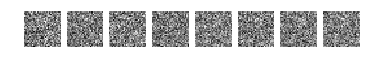

    0 [D loss: 0.420451, acc: 84.375%] [G loss: 0.658105]
  400 [D loss: 0.665551, acc: 50.000%] [G loss: 0.723541]
  800 [D loss: 0.596745, acc: 75.000%] [G loss: 0.745806]
 1200 [D loss: 0.566567, acc: 75.000%] [G loss: 0.889453]


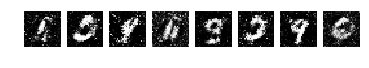

 1600 [D loss: 0.615070, acc: 68.750%] [G loss: 0.830291]
 2000 [D loss: 0.650430, acc: 53.125%] [G loss: 0.873377]
 2400 [D loss: 0.593908, acc: 65.625%] [G loss: 0.968149]
 2800 [D loss: 0.627452, acc: 65.625%] [G loss: 0.885579]


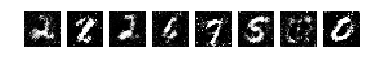

 3200 [D loss: 0.592817, acc: 65.625%] [G loss: 0.917417]
 3600 [D loss: 0.603181, acc: 62.500%] [G loss: 0.957142]
 4000 [D loss: 0.615975, acc: 68.750%] [G loss: 0.929820]
 4400 [D loss: 0.688729, acc: 59.375%] [G loss: 0.940234]


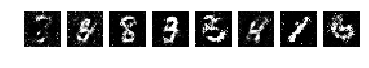

 4800 [D loss: 0.689252, acc: 59.375%] [G loss: 0.931167]
 5200 [D loss: 0.640717, acc: 68.750%] [G loss: 0.988023]
 5600 [D loss: 0.632133, acc: 59.375%] [G loss: 1.008021]
 6000 [D loss: 0.577818, acc: 75.000%] [G loss: 0.885752]


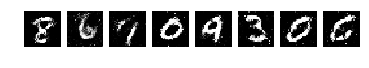

 6400 [D loss: 0.640917, acc: 71.875%] [G loss: 0.931115]
 6800 [D loss: 0.754585, acc: 46.875%] [G loss: 0.897447]
 7200 [D loss: 0.650926, acc: 56.250%] [G loss: 0.879993]
 7600 [D loss: 0.628716, acc: 68.750%] [G loss: 0.899671]


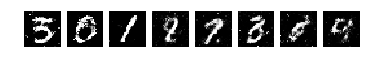

 8000 [D loss: 0.578648, acc: 84.375%] [G loss: 0.893934]
 8400 [D loss: 0.762023, acc: 46.875%] [G loss: 0.936806]
 8800 [D loss: 0.661834, acc: 56.250%] [G loss: 0.848439]
 9200 [D loss: 0.698992, acc: 50.000%] [G loss: 0.847531]


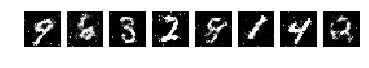

 9600 [D loss: 0.615445, acc: 68.750%] [G loss: 0.925531]
10000 [D loss: 0.634340, acc: 65.625%] [G loss: 0.905354]
10400 [D loss: 0.678263, acc: 43.750%] [G loss: 0.865808]
10800 [D loss: 0.658046, acc: 59.375%] [G loss: 0.907772]


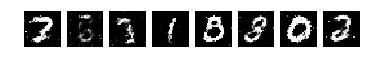

11200 [D loss: 0.728019, acc: 50.000%] [G loss: 0.892286]
11600 [D loss: 0.590133, acc: 84.375%] [G loss: 0.841661]
12000 [D loss: 0.651324, acc: 65.625%] [G loss: 0.869332]
12400 [D loss: 0.755050, acc: 43.750%] [G loss: 0.854277]


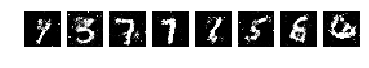

12800 [D loss: 0.760261, acc: 40.625%] [G loss: 0.789196]
13200 [D loss: 0.639660, acc: 56.250%] [G loss: 0.821718]
13600 [D loss: 0.710782, acc: 34.375%] [G loss: 0.815193]
14000 [D loss: 0.719744, acc: 59.375%] [G loss: 0.902704]


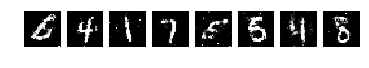

14400 [D loss: 0.733000, acc: 56.250%] [G loss: 0.795609]
14800 [D loss: 0.718944, acc: 46.875%] [G loss: 0.801004]
15200 [D loss: 0.695430, acc: 46.875%] [G loss: 0.768576]
15600 [D loss: 0.637239, acc: 59.375%] [G loss: 0.893400]


In [12]:
epochs = 16000 # 4800
batch_size = 32
progress_interval = 400
plot_interval = 1600

d_losses = []
d_accs = []
g_losses = []
halfb = int(batch_size/2)

for e in range(epochs):
    if e%plot_interval == 0:
        plot_imgs(e, generator)
        
    ##### DISCRIMINADOR
    idxs = np.random.randint(0, X_train.shape[0], halfb)
    imgs = X_train[idxs]
    noise = np.random.normal(0, 1, (halfb, 100)) # mu=0, sigma=1
    gen_imgs = generator.predict(noise)
    d_loss_real = discriminator.train_on_batch(imgs, 
                                               np.ones((halfb, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, 
                                               np.zeros((halfb, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    d_losses += [d_loss[0]] # loss
    d_accs += [d_loss[1]] # accuracy
    
    #### GERADOR
    noise = np.random.normal(0, 1, (batch_size, 100)) # mu=0, sigma=1
    label_y = np.array([1] * batch_size)
    g_loss = combined.train_on_batch(noise, label_y)
    g_losses += [g_loss]
    
    if e%progress_interval == 0:
        print('%5d [D loss: %.6f, acc: %.3f%%] [G loss: %.6f]' %
             (e, d_loss[0], 100*d_loss[1], g_loss))

Note que não há um critério muito claro de parada aqui. Você deve checar manualmente a qualidade dos dados gerados para ver se eles são apropriados e já é possível parar. Mas uma vez que você tem um gerador confiável e funcional, você pode replicar qualquer dígito. Em uma escala maior, você pode replicar coisas como textos de reviews, fotos, músicas... você tem uma máquina que parece efetivamente inteligente.

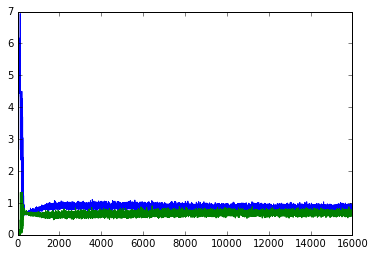

In [15]:
plt.plot(g_losses)
plt.plot(d_losses)

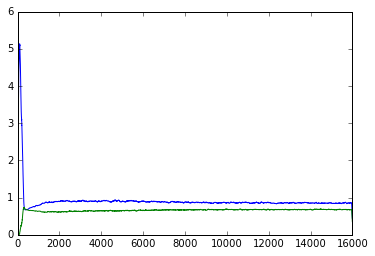

In [16]:
plt.plot(smooth(g_losses, 70))
plt.plot(smooth(d_losses, 70))

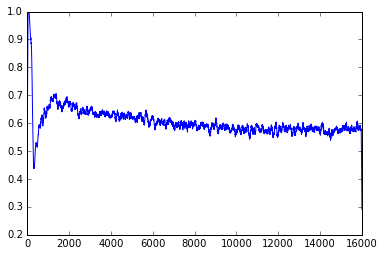

In [17]:
plt.plot(smooth(d_accs, 70))

## Outras arquiteturas para GANs

Muitas novas arquiteturas de GANs têm surgido na literatura. O site https://deephunt.in/the-gan-zoo-79597dc8c347 dá uma boa ideia da imensa diversidade de ideias nessa área. Abaixo, citamos algumas com implementações disponíveis:

* __ACGAN__ -- Auxiliary Classifier Generative Adversarial Network. Paper: https://arxiv.org/abs/1610.09585. Implementação: https://github.com/eriklindernoren/Keras-GAN/blob/master/acgan/acgan.py. 
* __Adversarial Autoencoders__. Paper: https://arxiv.org/abs/1511.05644. Implementação: https://github.com/eriklindernoren/Keras-GAN/blob/master/aae/adversarial_autoencoder.py.
* __BEGAN__ -- Boundary Equilibrium Generative Adversarial Networks. Paper: https://arxiv.org/abs/1703.10717. Implementação: https://github.com/carpedm20/BEGAN-tensorflow. Vamos ver BEGANs em detalhe na próxima aula.
* __BiGAN__ -- Bidirectional Generative Adversarial Network. Além de mapear o espaço latente $z$ para os dados, a GAN também aprende a mapear os dados de volta para o espaço latente. Ela é útil para aprendizado não- e semi-supervisionado já que mapeamento latente pode ser visto como um tipo de rotulação semântica. Paper: https://arxiv.org/abs/1605.09782. Implementação: https://github.com/eriklindernoren/Keras-GAN/blob/master/bigan/bigan.py.
    <img src="images/bigan.png" alt="exemplos BEGAN" style="width: 400px;"/>
* __CCGAN__ -- Semi-Supervised Learning with Context-Conditional Generative Adversarial Networks. Paper: https://arxiv.org/abs/1611.06430. Implementação: https://github.com/eriklindernoren/Keras-GAN/blob/master/ccgan/ccgan.py.
* __Context Encoder__: Paper: https://arxiv.org/abs/1604.07379. Implementação: https://github.com/eriklindernoren/Keras-GAN/blob/master/context_encoder/context_encoder.py.
* __DiscoGAN__: Paper: https://arxiv.org/pdf/1703.05192.pdf. Implementação: https://github.com/carpedm20/DiscoGAN-pytorch.
* __DCGAN__ -- Deep Convolutional Generative Adversarial Network. Gerador é uma rede de convolução. Normalmente usa técnicas de upsampling e convolução transposta para inverter a direção do sinal. Paper: https://arxiv.org/abs/1511.06434. Implementação: https://github.com/Zackory/Keras-MNIST-GAN.
* __InfoGAN__ -- Interpretable Representation Learning by Information Maximizing Generative Adversarial Nets. Paper: https://arxiv.org/abs/1606.03657. Implementação: https://github.com/eriklindernoren/Keras-GAN/blob/master/infogan/infogan.py.
* __SGAN__ -- Semi-supervised Generative Adversarial Network. Paper: https://arxiv.org/abs/1606.01583. Implementação: https://github.com/eriklindernoren/Keras-GAN/blob/master/sgan/sgan.py.
* __WGAN__ -- Wasserstein Generative Adversarial Network. Além de usar a distância de Wasserstein, essa GAN garante que o discriminador dê sempre gradientes úteis para o gerador (+1 se acerta real e -1, caso contrário). Paper: https://arxiv.org/abs/1701.07875. Implementação: https://github.com/eriklindernoren/Keras-GAN/blob/master/wgan/wgan.py.

Código baseado em Erik Lindernoren (https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py). Algumas figuras e ideias do blog de Faizan Shaikh (https://www.analyticsvidhya.com/blog/2017/06/introductory-generative-adversarial-networks-gans/).